In [2]:
#%pip install scipy matplotlib tqdm ipywidgets

In [3]:
import sys
import os
sys.path.append(os.path.abspath('') + '/build')
os.environ["OMP_NUM_THREADS"] = str(1)
os.environ["OMP_PLACES"] = "cores"
os.environ["OMP_PROC_BIND"] = "close"
import TreeSAT
from TreeSAT import SATTileTree
import numpy as np
import time
from tqdm import tqdm

In [11]:
#input = np.random.rand(256,512,1024,1)
input = np.random.rand(256,256,256,1)
tile_sizes = np.array(range(16,128+1)) #[4,8,10,16,25,32,48,50,64,128]
repetitions = 5

In [12]:
sizes = []
timings = []
tile_shapes = []
for tile_size in tqdm(tile_sizes):
    estimate = 0.0
    for i in range(repetitions):
        start = time.time()
        tree = SATTileTree(input, tile_size)
        elapsed = time.time() - start
        estimate += elapsed
    sizes.append(tree.size())
    tile_shapes.append(tree.tile_shape)
    timings.append(elapsed/repetitions)

tile_sizes = np.array(tile_sizes)
sizes = np.array(sizes) / (1024 * 1024)
timings = np.array(timings)
tile_shapes = np.array(tile_shapes)
print(sizes)
with np.printoptions(precision=2):
    print(timings)

100%|██████████| 113/113 [04:33<00:00,  2.42s/it]

[[ 64.          25.75008392]
 [ 76.74688339  28.93758392]
 [ 75.08468628  26.62476349]
 [ 71.79678345  24.03353119]
 [ 67.04711914  21.25402069]
 [ 77.6154213   23.36600494]
 [ 70.18945312  20.11824799]
 [ 80.20239258  21.93758392]
 [ 70.18945312  18.35982513]
 [ 79.3337822   19.88303375]
 [ 67.04711914  16.12862396]
 [ 75.08468628  17.36458588]
 [ 83.74023438  18.64632416]
 [ 67.82371902  14.56095123]
 [ 75.08468628  15.56208038]
 [ 82.84621811  16.59658051]
 [ 64.          12.40633392]
 [ 70.18945312  13.17977142]
 [ 76.765625    13.97664642]
 [ 83.74023438  14.79695892]
 [ 91.125       15.64070892]
 [ 66.27647018  11.05902863]
 [ 71.79678345  11.6556778 ]
 [ 77.6154213   12.26802826]
 [ 83.74023438  12.89608002]
 [ 90.17907333  13.53983307]
 [ 96.93978882  14.19928741]
 [ 65.51174927   9.36702728]
 [ 70.18945312   9.80208588]
 [ 75.08468628  10.24703217]
 [ 80.20239258  10.70186615]
 [ 85.54751587  11.16658783]
 [ 91.125       11.6411972 ]
 [ 96.93978882  12.12569427]
 [102.99682617

In [13]:
data_shape = input.shape[:3]
tile_alignment = np.empty((len(tile_sizes), len(data_shape)))
tile_alignment[:] = data_shape
num_tiles = np.ceil(tile_alignment / tile_sizes[:,None])
actual_data_shape = num_tiles * tile_sizes[:,None]
overhead_shape = actual_data_shape - data_shape
overhead_size = 4 * (np.prod(overhead_shape, axis=1) + 
                 overhead_shape[:,0] * data_shape[1] * data_shape[2] +
                 data_shape[0] * overhead_shape[:,1] * data_shape[2] +
                 data_shape[0] * data_shape[1] * overhead_shape[:,2]
                ) / (1024 * 1024)

raw_data_size = 4 * np.prod(data_shape) / (1024 * 1024)

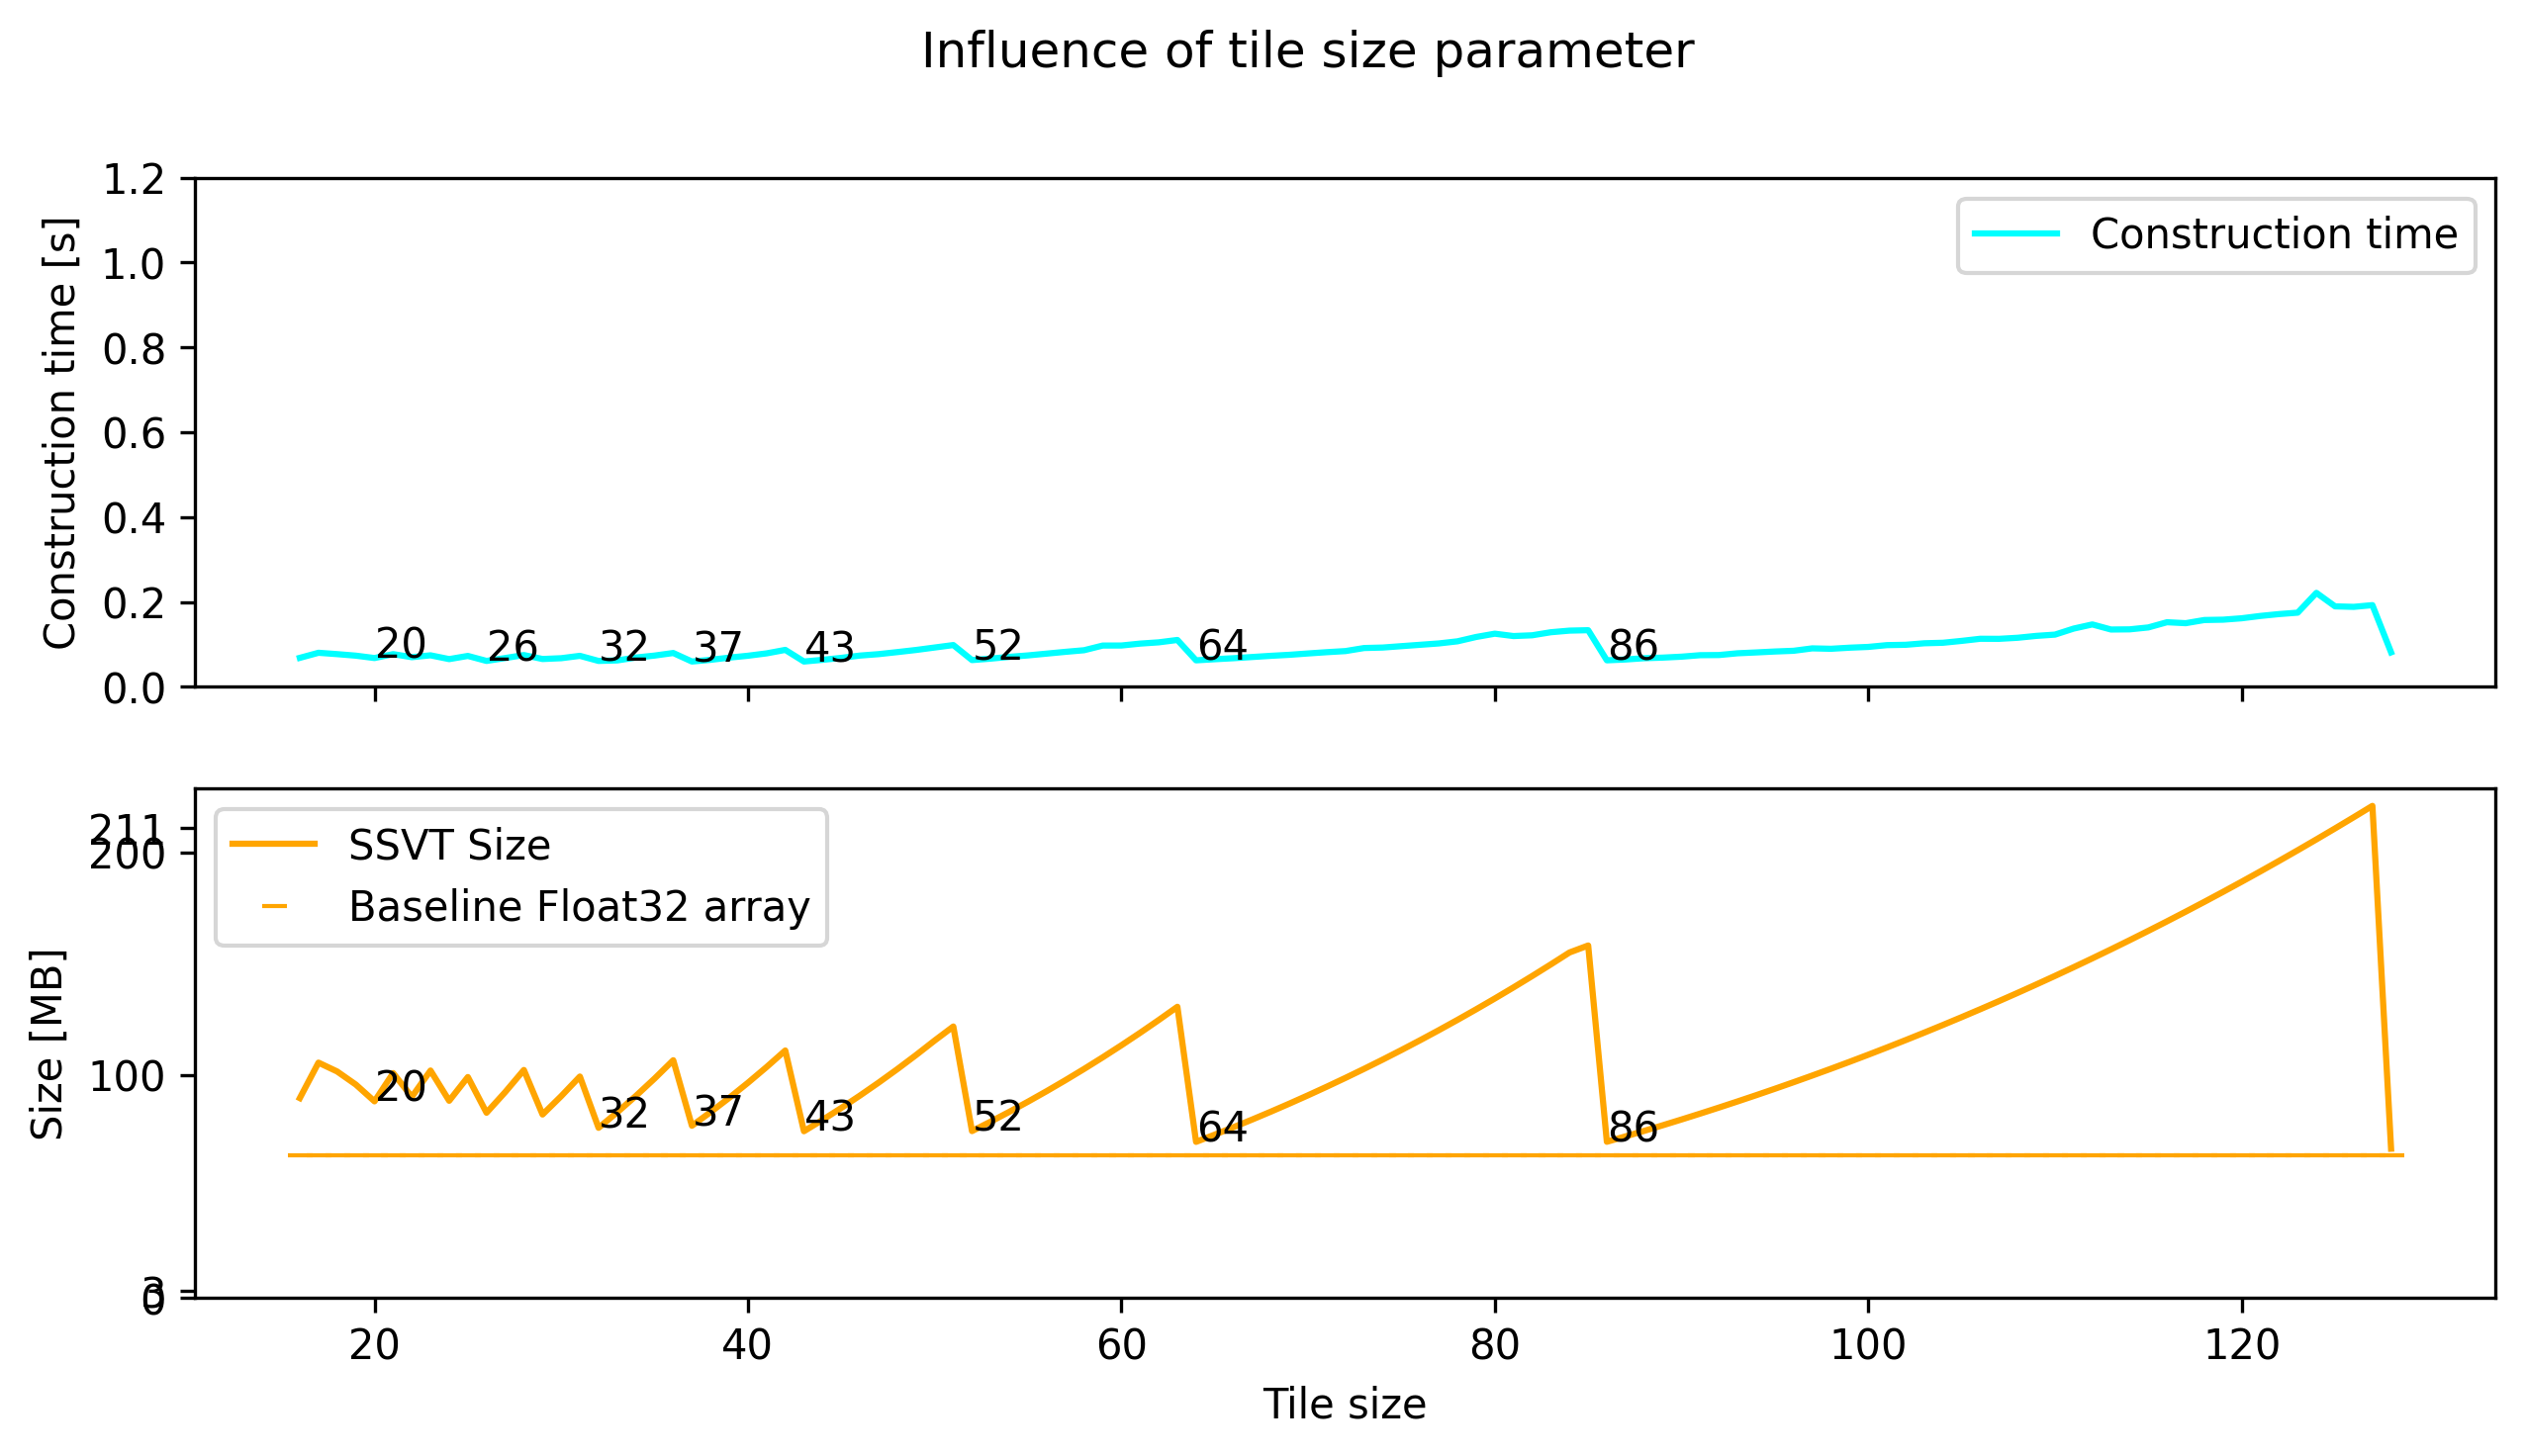

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import argrelmin

def minima(value_array, axes=None, anotate=True):
    minima_indices = argrelmin(value_array, order=3)[0]
    if anotate and axes:
        for minimum in zip(tile_sizes[minima_indices], value_array[minima_indices]):
            axes.annotate(f'{minimum[0]}', minimum)
    return minima_indices

def min_max_ticks(value_array, spacing = 2):
    low, high = np.min(value_array), np.max(value_array)
    r = np.arange(spacing* ((low // spacing) + 1), spacing* ((high // spacing)+1), spacing)
    return [0, low, *r, high]


fig = plt.figure(figsize=(10,5), dpi=300)
(ax1, ax2) = fig.subplots(2,1, sharex=True)
fig.suptitle('Influence of tile size parameter')

ax1.set_ylim(0,1.2)
ax1.set_ylabel('Construction time [s]')
#ax1.set_yticks(min_max_ticks(timings, 0.5))
timeline, = ax1.plot(tile_sizes, timings, color='cyan', label='Construction time')
ax1.legend(handles=[timeline])

#ax2 = ax1.twinx()
dataline,= ax2.plot(tile_sizes, np.sum(sizes, axis=1), color='orange', label='SSVT Size')
ax2.set_xlabel('Tile size')
ax2.set_ylim(0)
ax2.set_ylabel('Size [MB]')
ax2.set_yticks(min_max_ticks(sizes, 100))
baseline, = ax2.plot(tile_sizes, np.repeat(raw_data_size, len(tile_sizes)), '_', color='orange', label='Baseline Float32 array')
ax2.legend(handles=[dataline, baseline])
minima(timings, ax1)
minima(np.sum(sizes, axis=1), ax2);
#plt.xticks(tile_sizes)
plt.savefig('tile_size_1t.png')

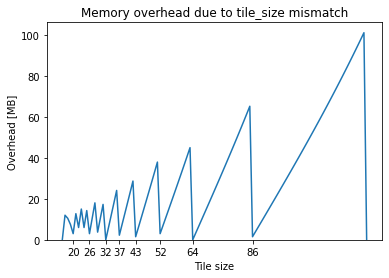

In [15]:
fig, ax1 = plt.subplots()
plt.plot(tile_sizes, overhead_size)
plt.xlabel('Tile size')
plt.ylabel('Overhead [MB]')
plt.ylim(0)
plt.title('Memory overhead due to tile_size mismatch')
plt.xticks(tile_sizes[minima(overhead_size)]);
# ax2 = ax1.twinx()
# ax2.plot(tile_sizes, sizes - overhead_size, 'r')
# ax2.set_ylabel('Overhead [%]')
#ax2.set_ylim(0.0, 1.0)


C:\Users\cgg\AppData\Local\Temp\ipykernel_20708\491160065.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0)


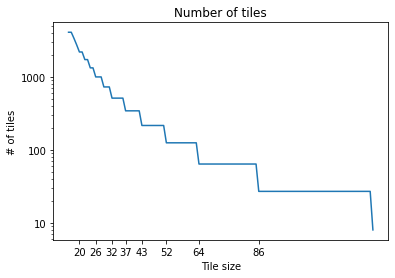

In [16]:
from matplotlib.ticker import ScalarFormatter
fig, ax1 = plt.subplots()
plt.plot(tile_sizes, np.prod(num_tiles, axis=1))
plt.xlabel('Tile size')
plt.ylabel('# of tiles')
plt.yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter())
plt.ylim(0)
plt.title('Number of tiles')
plt.xticks(tile_sizes[minima(overhead_size)]);

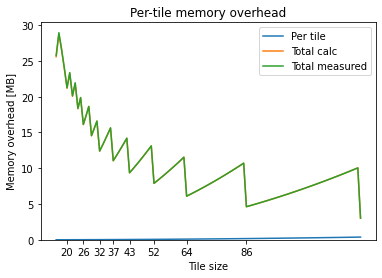

In [18]:
tile_overhead = np.zeros((len(tile_sizes)))
tile_overhead += 4 # constant integer offset
tile_overhead += 2 # tilesize
tile_overhead += 3 * (tile_sizes+1) * tile_sizes * 8 # 3 previous walls in double
tile_overhead += 16 # variant deciding sparsity / holding pointer
tile_overhead = tile_overhead / (1024*1024)
fig, ax1 = plt.subplots()
plt.plot(tile_sizes, tile_overhead, label='Per tile')
plt.plot(tile_sizes, tile_overhead * np.prod(num_tiles, axis=1), label='Total calc')
plt.plot(tile_sizes, sizes[:,1], label='Total measured')
plt.xlabel('Tile size')
plt.ylabel('Memory overhead [MB]')
plt.ylim(0)
plt.legend()
plt.title('Per-tile memory overhead')
plt.xticks(tile_sizes[minima(overhead_size)]);